In [27]:
import pandas as pd
import numpy as np
import math
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('tmax_cr2met_C_day.csv')
data_etp = pd.read_csv('pet_hargreaves_mm_day.csv')
data_prec = pd.read_csv('precip_cr2met_mm_day.csv')

# Convertir la columna 'date' a tipo datetime
data['date'] = pd.to_datetime(data['date'])
data_etp['date'] = pd.to_datetime(data_etp['date'])
data_prec['date'] = pd.to_datetime(data_prec['date'])

# Renombrar la columna '10121001'
data.rename(columns={'10121001': 'temp'}, inplace=True)
data_etp.rename(columns={'10121001': 'etp'}, inplace=True)
data_prec.rename(columns={'10121001': 'prec'}, inplace=True)

# Unir los tres conjuntos de datos por la columna 'date'
merged_data = pd.merge(data, data_etp, on='date', how='inner')
merged_data = pd.merge(merged_data, data_prec, on='date', how='inner')

merged_data = merged_data[['date', 'temp', 'etp', 'prec']]

In [3]:
merged_data

,date,temp,etp,prec
0,1979-01-01,22.369885,5.362,0.000000
1,1979-01-02,24.961370,6.051,0.000000
2,1979-01-03,24.957367,5.966,0.000000
3,1979-01-04,27.171364,6.541,0.000000
4,1979-01-05,27.877665,6.647,0.000000
...,...,...,...,...
15091,2020-04-26,16.785367,1.752,6.078806
15092,2020-04-27,16.238913,1.405,8.518495
15093,2020-04-28,15.332504,1.411,1.306179
15094,2020-04-29,15.221187,1.577,0.000000


In [4]:
# Comprobar orden cronológico
is_ordered = merged_data['date'].is_monotonic_increasing

if is_ordered:
    print("La columna 'date' está en orden cronológico.")
else:
    print("La columna 'date' no está en orden cronológico.")

La columna 'date' está en orden cronológico.


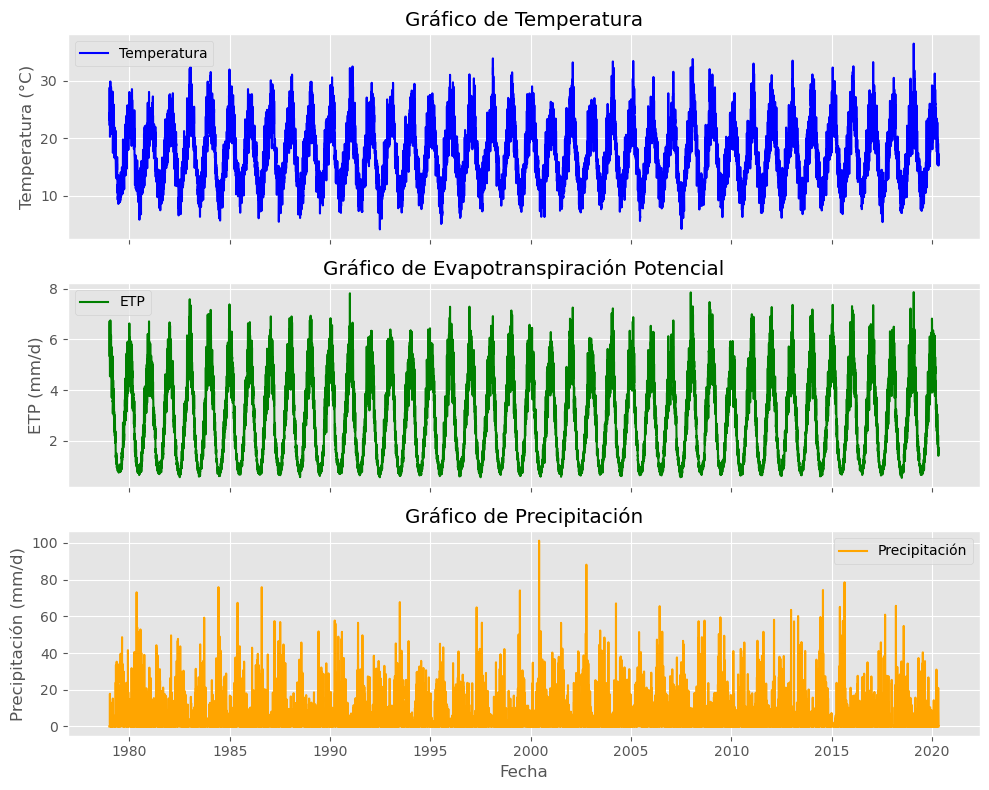

In [5]:
# Configurar el tamaño de la figura y los subgráficos
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

# Graficar temperatura en el primer subgráfico
sns.lineplot(x='date', y='temp', data=merged_data, ax=axes[0], label='Temperatura', color='blue')
axes[0].set_ylabel('Temperatura (°C)')
axes[0].set_title('Gráfico de Temperatura')

# Graficar evapotranspiración potencial en el segundo subgráfico
sns.lineplot(x='date', y='etp', data=merged_data, ax=axes[1], label='ETP', color='green')
axes[1].set_ylabel('ETP (mm/d)')
axes[1].set_title('Gráfico de Evapotranspiración Potencial')

# Graficar precipitación en el tercer subgráfico
sns.lineplot(x='date', y='prec', data=merged_data, ax=axes[2], label='Precipitación', color='orange')
axes[2].set_ylabel('Precipitación (mm/d)')
axes[2].set_title('Gráfico de Precipitación')

plt.xlabel('Fecha')

plt.tight_layout()
plt.show()

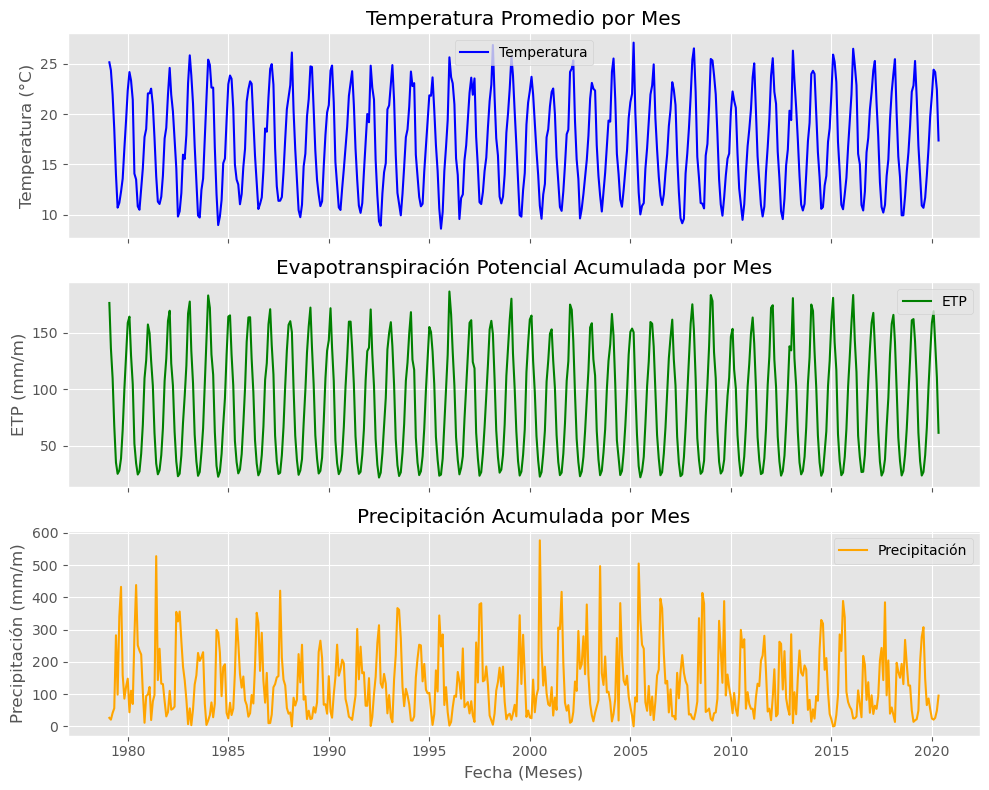

In [6]:
# Establecer 'date' como índice
merged_data.set_index('date', inplace=True)

# Agrupar por mes y realizar operaciones específicas en cada columna
monthly_data = merged_data.resample('M').agg({'temp': 'mean', 'etp': 'sum', 'prec': 'sum'})

# Reiniciar 'date' como una columna
monthly_data.reset_index(inplace=True)

# Configurar el tamaño de la figura y los subgráficos
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

# Graficar temperatura promedio por mes
sns.lineplot(x='date', y='temp', data=monthly_data, ax=axes[0], label='Temperatura', color='blue')
axes[0].set_ylabel('Temperatura (°C)')
axes[0].set_title('Temperatura Promedio por Mes')

# Graficar evapotranspiración potencial acumulada por mes
sns.lineplot(x='date', y='etp', data=monthly_data, ax=axes[1], label='ETP', color='green')
axes[1].set_ylabel('ETP (mm/m)')
axes[1].set_title('Evapotranspiración Potencial Acumulada por Mes')

# Graficar precipitación acumulada por mes
sns.lineplot(x='date', y='prec', data=monthly_data, ax=axes[2], label='Precipitación', color='orange')
axes[2].set_ylabel('Precipitación (mm/m)')
axes[2].set_title('Precipitación Acumulada por Mes')

# Configurar el eje x común
plt.xlabel('Fecha (Meses)')

plt.tight_layout()
plt.show()

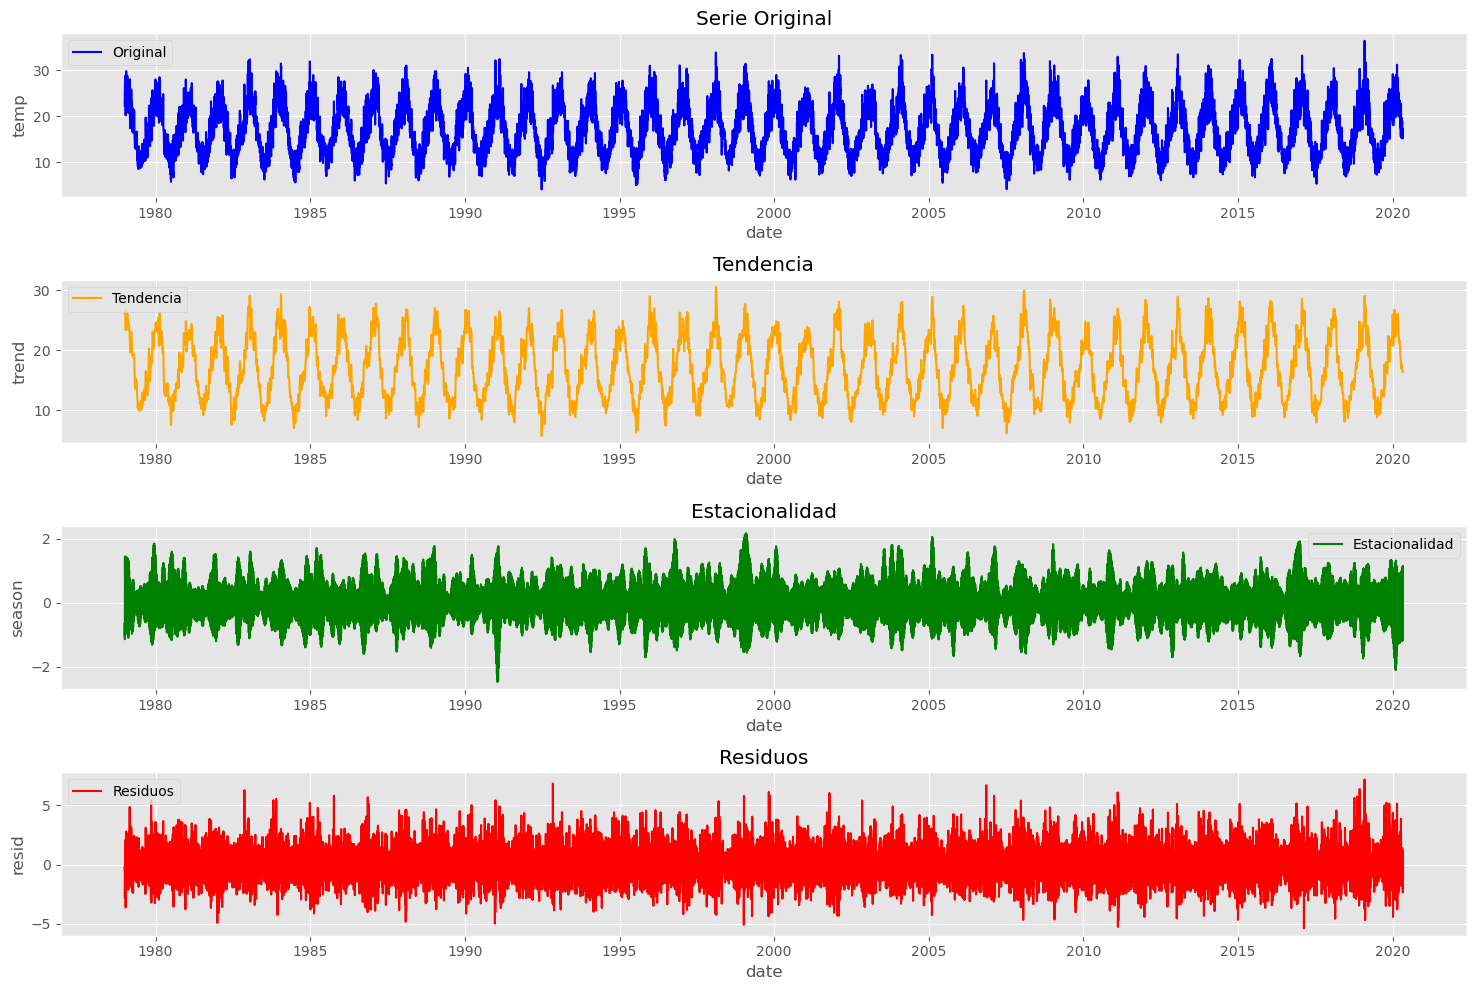

In [7]:
# Especificar la frecuencia
freq = 13

# Realizar la descomposición STL
stl_result = STL(merged_data['temp'], seasonal=freq).fit()

# Visualizar la serie original, tendencia, estacionalidad y residuos
plt.figure(figsize=(15, 10))

# Serie Original
plt.subplot(4, 1, 1)
sns.lineplot(data=merged_data['temp'], label='Original', color='blue')
plt.title('Serie Original')

# Tendencia
plt.subplot(4, 1, 2)
sns.lineplot(data=stl_result.trend, label='Tendencia', color='orange')
plt.title('Tendencia')

# Estacionalidad
plt.subplot(4, 1, 3)
sns.lineplot(data=stl_result.seasonal, label='Estacionalidad', color='green')
plt.title('Estacionalidad')

# Residuos
plt.subplot(4, 1, 4)
sns.lineplot(data=stl_result.resid, label='Residuos', color='red')
plt.title('Residuos')

plt.tight_layout()
# Guardar la imagen con ajuste de resolución
# plt.savefig('STL.png', dpi=500)
plt.show()

La gráfica de la la descomposición STL se puede interpretar de la siguiente forma:

La serie original muestra una variación considerable de la temperatura a lo largo de los años, con algunos picos y valles pronunciados. También se puede notar una cierta periodicidad anual, con temperaturas más altas en los meses de verano y más bajas en los meses de invierno.

El componente de tendencia muestra una línea suave que se curva ligeramente hacia arriba, lo que indica una tendencia creciente de la temperatura a lo largo del tiempo. Esto podría sugerir un efecto del calentamiento global o de otros factores climáticos.

El componente estacional muestra una oscilación regular que se repite cada año, lo que refleja el patrón estacional de la temperatura. Se puede ver que la amplitud de la oscilación varía según el año, lo que podría deberse a la variabilidad natural del clima o a eventos extremos como sequías o inundaciones.

El componente residual muestra una línea que fluctúa alrededor del cero, lo que indica las variaciones residuales después de tener en cuenta la tendencia y la estacionalidad. Se puede ver que la línea tiene algunos picos y valles aislados, lo que podría indicar errores de medición, anomalías o ruido aleatorio.

In [8]:
# Prueba de Dickey-Fuller Aumentada (ADF) para estacionariedad
result = adfuller(merged_data['temp'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Resultados de la Prueba:')
print('La serie es estacionaria.' if result[1] <= 0.05 else 'La serie no es estacionaria.')

ADF Statistic: -9.935528528557823
p-value: 2.7501998269795756e-17
Resultados de la Prueba:
La serie es estacionaria.


La prueba de Dickey-Fuller aumentada (ADF) es una prueba de raíz unitaria para la estacionariedad. La estacionariedad significa que las propiedades estadísticas de una serie de tiempo, como la media y la varianza, no cambian a lo largo del tiempo. El p-value es 2.7501998269795756e-17. El nivel de significancia es el umbral que se utiliza para decidir si rechazar o no la hipótesis nula. Por lo general, se elige un nivel de significancia del 5 % o menor. Por lo tanto, se rechaza la hipótesis nula de una raíz unitaria y se concluye que la serie de tiempo es estacionaria.

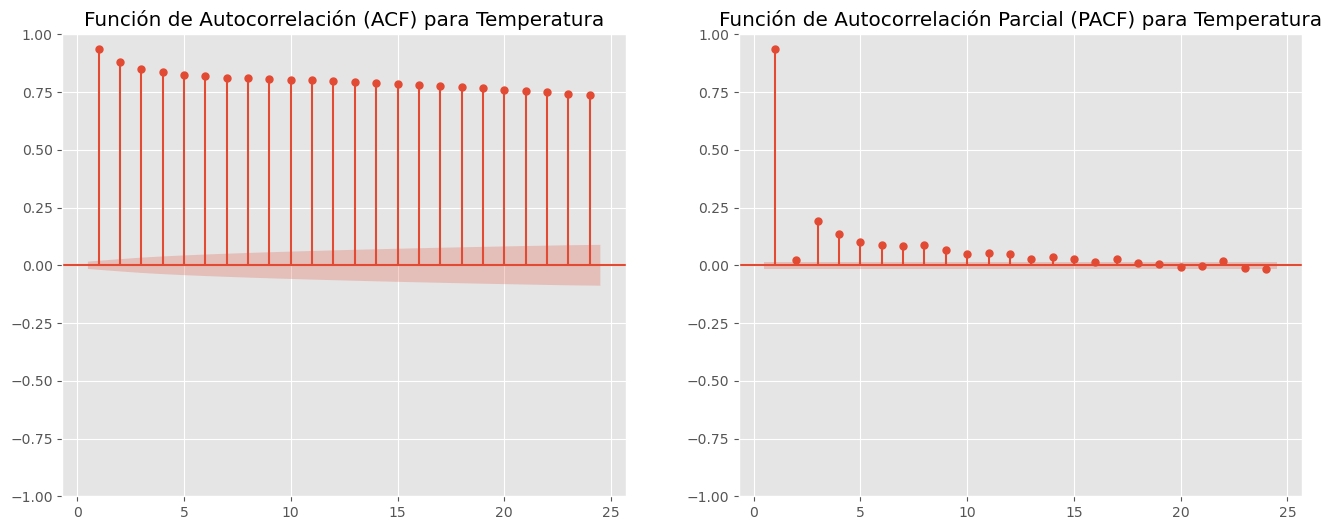

In [9]:
# Configurar el tamaño de la figura para ambos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Función de Autocorrelación (ACF)
plot_acf(merged_data['temp'], lags=24, zero=False, ax=ax1)
ax1.set_title('Función de Autocorrelación (ACF) para Temperatura')

# Función de Autocorrelación Parcial (PACF)
plot_pacf(merged_data['temp'], lags=24, zero=False, ax=ax2)
ax2.set_title('Función de Autocorrelación Parcial (PACF) para Temperatura')

# Guardar la imagen con ajuste de resolución
plt.savefig('ACF-PACF.png', dpi=200)
plt.show()

Las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) son herramientas útiles para identificar la estructura de dependencia temporal de los datos.

La ACF muestra una correlación significativa en muchos retrasos, lo que indica una fuerte tendencia estacional o cíclica en los datos.
La PACF, por otro lado, muestra una caída brusca en la correlación después del primer retraso, lo que puede indicar un modelo AR(1) como un buen ajuste para estos datos..

<Figure size 600x600 with 0 Axes>

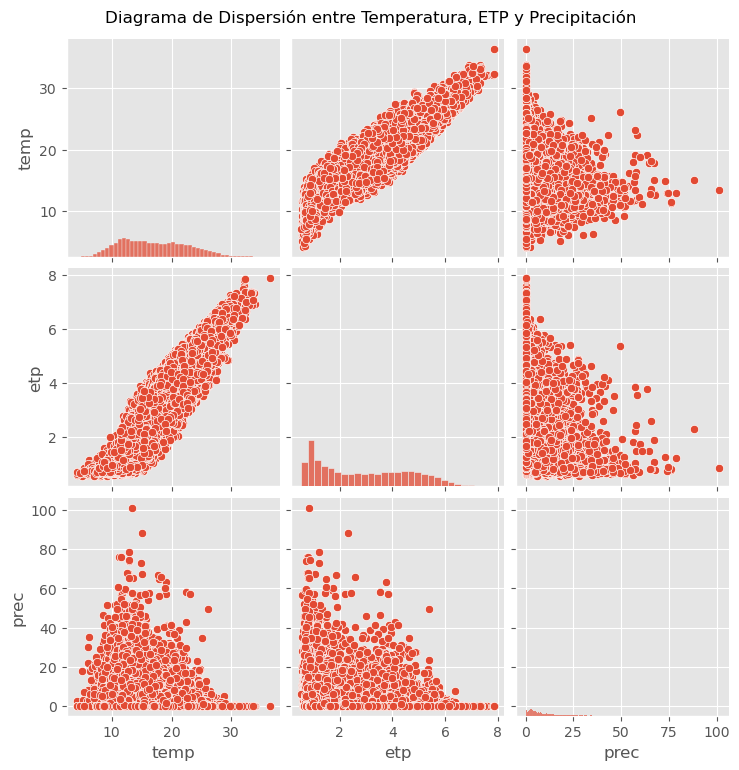

In [10]:
# Diagrama de dispersión entre temp, etp y prec
plt.figure(figsize=(6, 6))
scatter_plot = sns.pairplot(merged_data[['temp', 'etp', 'prec']])
scatter_plot.fig.suptitle('Diagrama de Dispersión entre Temperatura, ETP y Precipitación', y=1.02)
# Guardar la imagen con ajuste de resolución
# plt.savefig('dispersión.png', dpi=200)
plt.show();

En el diagrama de dispersión se puede observar lo siguiente:

Hay una correlación positiva entre temp y etp, indicando que a medida que la temperatura aumenta, la evapotranspiración potencial también lo hace. Esto tiene sentido desde el punto de vista físico, ya que la evapotranspiración es el proceso por el cual el agua se evapora de la superficie terrestre y de la vegetación, y este proceso depende de la temperatura.

No hay una correlación clara entre prec y las otras dos variables. Los puntos se distribuyen de forma aleatoria, sin mostrar una tendencia lineal. Esto significa que la precipitación no depende de la temperatura ni de la evapotranspiración potencial, o que depende de otros factores.

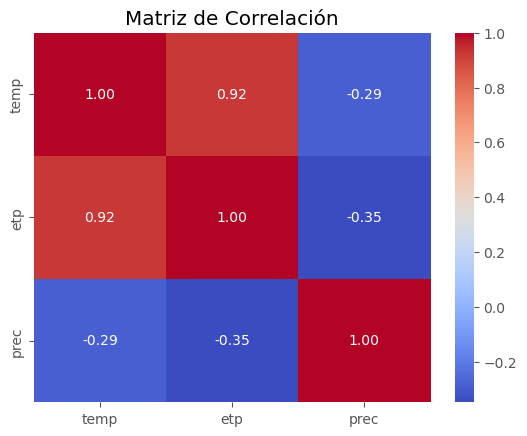

In [11]:
# Matriz de correlación
correlation_matrix = merged_data[['temp', 'etp', 'prec']].corr()

# Mapa de calor de la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

Correlación entre 'temp' y 'etp' (0.92): Hay una correlación positiva muy fuerte entre 'temp' y 'etp', lo cual sugiere una relación lineal positiva significativa entre la temperatura y la evapotranspiración potencial. Es probable que un aumento en la temperatura se asocie con un aumento en la evapotranspiración potencial.

Correlación entre 'temp' y 'prec' (-0.29): Hay una correlación negativa moderada entre estas dos variables. Esto sugiere que a medida que la temperatura aumenta, la precipitación tiende a disminuir.

Correlación entre 'etp' y 'prec' (-0.35): Hay una correlación negativa moderada entre 'etp' y 'prec'. Esto sugiere que a medida que la evapotranspiración aumenta, la precipitación tiende a disminuir.

Análisis de regresión lineal simple para cada regresor por separado.

In [12]:
# Regresión lineal para 'etp'
X_etp = sm.add_constant(merged_data['etp'])
model_etp = sm.OLS(merged_data['temp'], X_etp).fit()
print(model_etp.summary())

# Regresión lineal para 'prec'
X_prec = sm.add_constant(merged_data['prec'])
model_prec = sm.OLS(merged_data['temp'], X_prec).fit()
print(model_prec.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                 8.943e+04
Date:                Fri, 26 Jan 2024   Prob (F-statistic):               0.00
Time:                        13:37:24   Log-Likelihood:                -32256.
No. Observations:               15096   AIC:                         6.452e+04
Df Residuals:                   15094   BIC:                         6.453e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7220      0.032    268.538      0.0

Para ETP, el modelo explica aproximadamente el 85.6% de la variabilidad en 'temp'. El coeficiente de 'etp' es positivo y significativo, indicando una relación positiva entre 'etp' y 'temp'.

Para Precipitación, el modelo explica aproximadamente el 8.4% de la variabilidad en 'temp'. El coeficiente de 'prec' es negativo y significativo, indicando una relación negativa entre 'prec' y 'temp'.

Análisis de regresión múltiple incluyendo ambos regresores.

In [13]:
X = sm.add_constant(merged_data[['etp', 'prec']])
model_multi = sm.OLS(merged_data['temp'], X).fit()
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                 4.514e+04
Date:                Fri, 26 Jan 2024   Prob (F-statistic):               0.00
Time:                        13:37:24   Log-Likelihood:                -32194.
No. Observations:               15096   AIC:                         6.439e+04
Df Residuals:                   15093   BIC:                         6.442e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5046      0.038    225.213      0.0

El modelo OLS indica que 'etp' y 'prec' son significativos para predecir 'temp' y que el modelo en su conjunto es estadísticamente significativo. Sin embargo, algunos diagnósticos de residuos sugieren que podría haber autocorrelación positiva y desviación de la normalidad en los residuos, lo cual podría requerir más análisis y ajustes en el modelo. Además, el R-squared sugiere que el modelo explica una proporción considerable de la variabilidad en 'temp'.

300 100
Epoch 1/50
30/30 [==============================] - 5s 43ms/step - loss: 0.0990 - val_loss: 0.0149
Epoch 2/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0085 - val_loss: 0.0049
Epoch 3/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 4/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 6/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 7/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 9/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 10/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 11/5

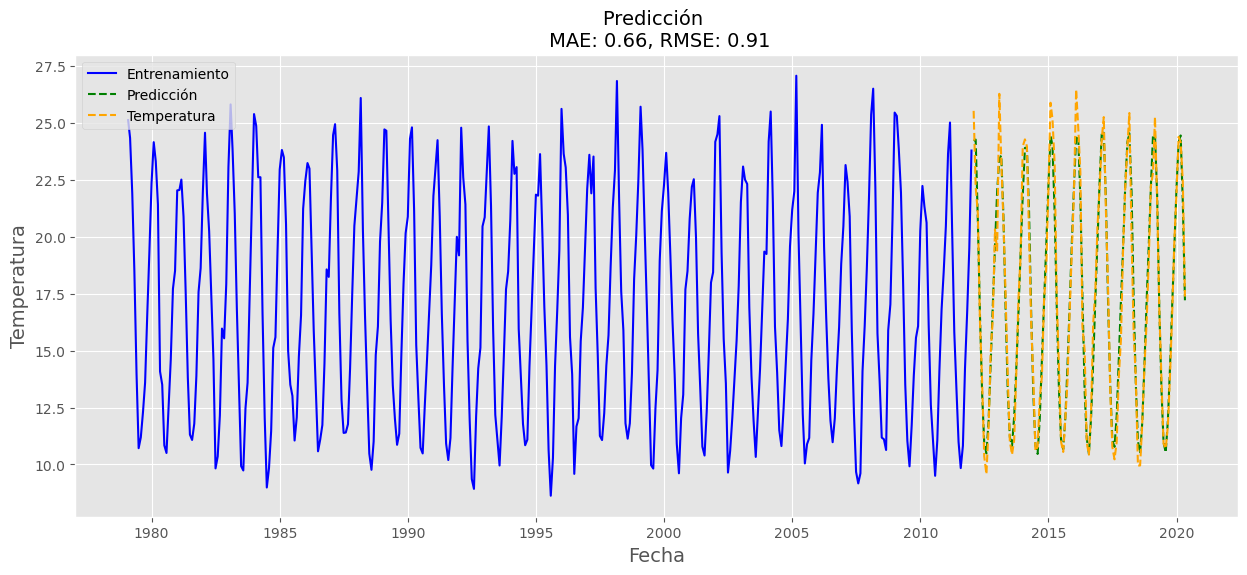

In [28]:
monthly_data.reset_index(inplace=True)
lstm = monthly_data[['date', 'temp']].copy()
lstm.columns = ['ds', 'y']

# Convierte el DataFrame a un array de Numpy
data = lstm.filter(['y'])
dataset = data.values

# Normalización de datos
scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

# Define el tamaño de la ventana
look_back = 48

# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(scaled_data) * 0.80)
train, test = scaled_data[:train_size-look_back, :], scaled_data[train_size-look_back:, :]

# Función para crear conjuntos de datos
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

# Crea conjuntos de datos de entrenamiento y prueba
x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# Reorganiza la entrada para que sea [muestras, pasos de tiempo, características]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

# Imprime la longitud de los conjuntos de entrenamiento y prueba
print(len(x_train), len(x_test))

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo
model.fit(x_train, y_train, batch_size=10, epochs=50, validation_data=(x_test, y_test))

# Imprime el resumen del modelo
model.summary()

# Realiza predicciones con el modelo
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Invierte las predicciones a la escala original
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calcula el error cuadrático medio (RMSE) y el error absoluto medio (MAE)
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:, 0])

# Imprime las métricas
print('RMSE: {}'.format(score_rmse))

# Plotea las predicciones
x_train_ticks = lstm.head(train_size)['ds']
y_train = lstm.head(train_size)['y']
x_test_ticks = lstm.tail(len(test_predict))['ds']

f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Entrenamiento', linestyle='solid', color='blue')
sns.lineplot(x=x_test_ticks, y=test_predict[:, 0], ax=ax, linestyle='dashed', color='green', label='Predicción')
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, linestyle='dashed', color='orange', label='Temperatura')

ax.set_title(f'Predicción \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Fecha', fontsize=14)
ax.set_ylabel(ylabel='Temperatura', fontsize=14)

plt.show()

1/1 [==============================] - 0s 30ms/step


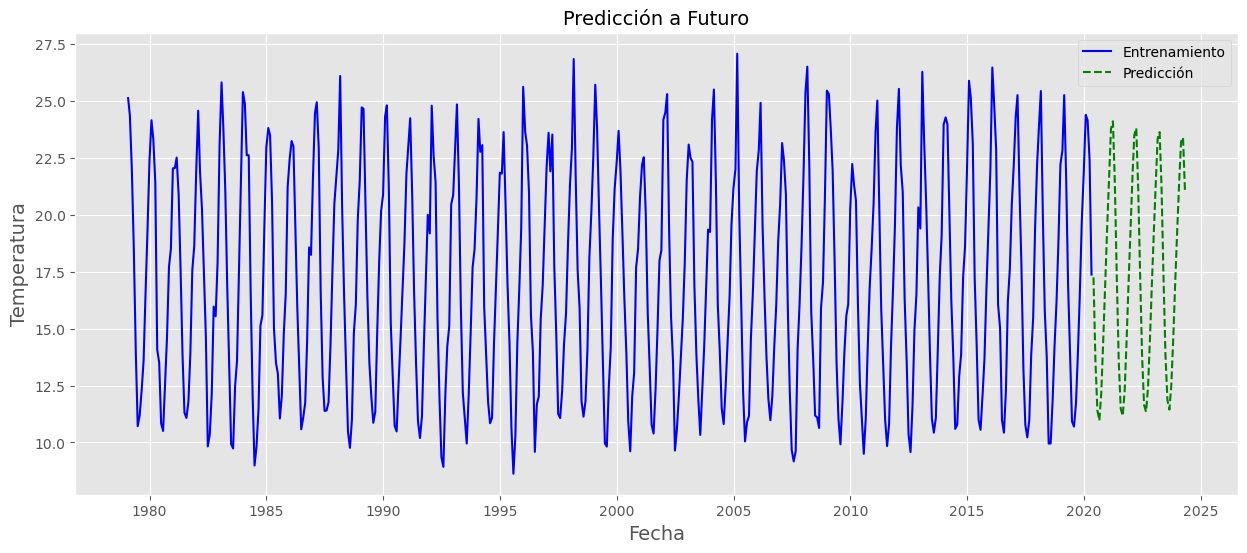

In [15]:
# Cantidad de meses a predecir en el futuro
num_months_to_predict = 48

# Obtener los últimos 48 puntos de entrenamiento
last_48_points = np.array(x_test[-1, 0, :]).tolist()

# Lista para almacenar las predicciones
future_predictions = []

# Realiza predicciones para cada mes futuro
for i in range(num_months_to_predict):
    # Crear secuencia de entrada
    input_sequence = np.array(last_48_points).reshape(1, 1, -1)

    # Realizar la predicción
    future_prediction = model.predict(input_sequence)

    # Actualizar la secuencia de entrada
    last_48_points = last_48_points[1:] + [float(future_prediction[0, 0])]

    # Almacenar la predicción en la lista
    future_predictions.append(future_prediction[0, 0])

# Invertir la escala de las predicciones
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Crear un rango de fechas para los meses futuros
future_dates = pd.date_range(start=lstm['ds'].max(), periods=num_months_to_predict + 1, freq='M')[1:]

# Gráfica de las predicciones
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

# Gráfica de los datos de entrenamiento
ax.plot(lstm['ds'], lstm['y'], label='Entrenamiento', linestyle='solid', color='blue')

# Gráfica de las predicciones a futuro
ax.plot(future_dates, future_predictions, linestyle='dashed', color='green', label='Predicción')

ax.set_title('Predicción a Futuro', fontsize=14)
ax.set_xlabel(xlabel='Fecha', fontsize=14)
ax.set_ylabel(ylabel='Temperatura', fontsize=14)
ax.legend()

plt.show()

Los resultados de la nueva configuración del modelo LSTM entrenado con datos agrupados mensualmente indican lo siguiente:

La pérdida en el conjunto de entrenamiento y validación disminuye a medida que avanzan las épocas. Esto es indicativo de que el modelo está aprendiendo bien y generalizando correctamente para predecir la temperatura mensual.

El valor del RMSE en el conjunto de prueba es 0.9126. Este valor indica que, en promedio, las predicciones del modelo difieren alrededor de 0.9126 grados Celsius de los valores reales. 
Un RMSE de este tamaño podría considerarse bajo  sugiriendo un buen ajuste del modelo a los datos mensuales

El MAE es 0.67. Este valor indica que, en promedio, las predicciones del modelo difieren alrededor de 0.67 grados Celsius de los valores reales. 
Al igual que el RMSE, un MAE bajo sugiere un buen rendimiento del modelo

El modelo LSTM tiene dos capas LSTM, una capa densa con 25 neuronas y otra capa densa con 1 neurona. El total de parámetros es de 141,683, lo que indica una complejidad moderada del modelo. 
La arquitectura parece ser suficientemente compleja para capturar patrones en los datospromedio  mensuales de temperatura...

A continuación se procede a implementar modelo Prophet, para esta implementación, se utilizarán los registros diarios.

13:37:47 - cmdstanpy - INFO - Chain [1] start processing
13:37:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/61 [00:00<?, ?it/s]

13:37:47 - cmdstanpy - INFO - Chain [1] start processing
13:38:10 - cmdstanpy - INFO - Chain [1] done processing
13:38:10 - cmdstanpy - INFO - Chain [1] start processing
13:38:11 - cmdstanpy - INFO - Chain [1] done processing
13:38:11 - cmdstanpy - INFO - Chain [1] start processing
13:38:11 - cmdstanpy - INFO - Chain [1] done processing
13:38:11 - cmdstanpy - INFO - Chain [1] start processing
13:38:12 - cmdstanpy - INFO - Chain [1] done processing
13:38:12 - cmdstanpy - INFO - Chain [1] start processing
13:38:13 - cmdstanpy - INFO - Chain [1] done processing
13:38:13 - cmdstanpy - INFO - Chain [1] start processing
13:38:13 - cmdstanpy - INFO - Chain [1] done processing
13:38:13 - cmdstanpy - INFO - Chain [1] start processing
13:38:14 - cmdstanpy - INFO - Chain [1] done processing
13:38:14 - cmdstanpy - INFO - Chain [1] start processing
13:38:14 - cmdstanpy - INFO - Chain [1] done processing
13:38:15 - cmdstanpy - INFO - Chain [1] start processing
13:38:15 - cmdstanpy - INFO - Chain [1]

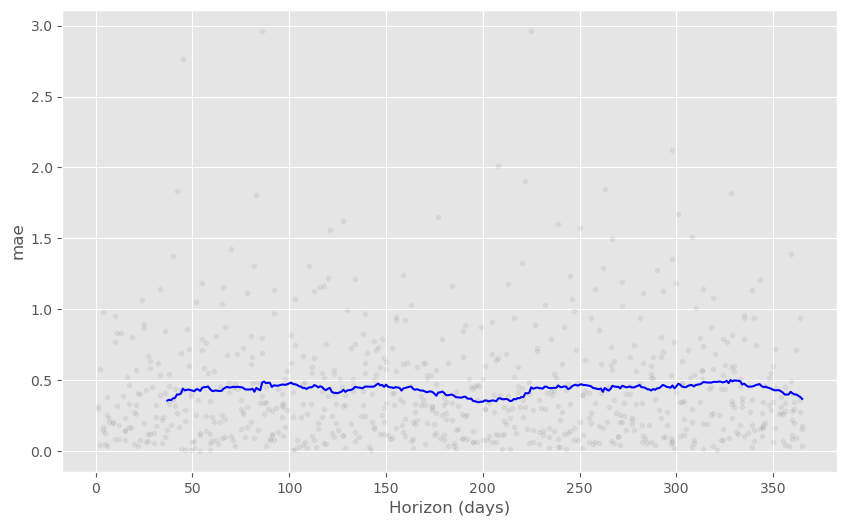

In [16]:
prophet_data = monthly_data[['date', 'temp', 'etp', 'prec']].copy()
prophet_data.columns = ['ds', 'y', 'etp', 'prec']

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size_prophet = int(len(prophet_data) * 0.80)
train_prophet, test_prophet = prophet_data[:train_size_prophet], prophet_data[train_size_prophet:]

# Inicializar el modelo Prophet
model_prophet = Prophet()
model_prophet.add_regressor('etp')
model_prophet.add_regressor('prec')

# Ajustar el modelo Prophet
model_prophet.fit(train_prophet)

# Realizar validación cruzada
df_cv = cross_validation(model_prophet, initial='730 days', period='180 days', horizon='365 days')

# Calcular métricas de rendimiento
df_p = performance_metrics(df_cv)

# Visualizar las métricas de validación cruzada
fig = plot_cross_validation_metric(df_cv, metric='mae')

# Crear un DataFrame con fechas futuras para realizar predicciones
future = model_prophet.make_future_dataframe(periods=48, freq='M')
future = future.merge(prophet_data, on='ds')

# Realizar predicciones
forecast = model_prophet.predict(future)

In [17]:
merged_data.reset_index(inplace=True)
prophet_data = merged_data[['date', 'temp', 'etp', 'prec']]

# Renombrar columnas para que coincidan con el ejemplo
prophet_data = prophet_data.rename(columns={'date': 'ds', 'temp': 'y', 'etp': 'etp', 'prec': 'prec'})

# Dividir el conjunto de datos en entrenamiento y prueba
train_size = int(0.85 * len(prophet_data))
train = prophet_data.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(prophet_data.iloc[:train_size, [0, 2, 3]]), pd.DataFrame(prophet_data.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(prophet_data.iloc[train_size:, [0, 2, 3]]), pd.DataFrame(prophet_data.iloc[train_size:, 1])

# Crear y ajustar el modelo Prophet
model = Prophet()
model.add_regressor('etp')
model.add_regressor('prec')

# Ajustar el modelo con el conjunto de entrenamiento
train_data = pd.concat([x_train, y_train], axis=1)
train_data.columns = ['ds', 'etp', 'prec', 'y']
model.fit(train_data)

# Realizar predicciones en el conjunto de prueba
valid_data = pd.concat([x_valid, y_valid], axis=1)
valid_data.columns = ['ds', 'etp', 'prec', 'y']
y_pred = model.predict(valid_data)

# Calcular métricas
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

13:38:36 - cmdstanpy - INFO - Chain [1] start processing
13:38:40 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1.1642202238467774


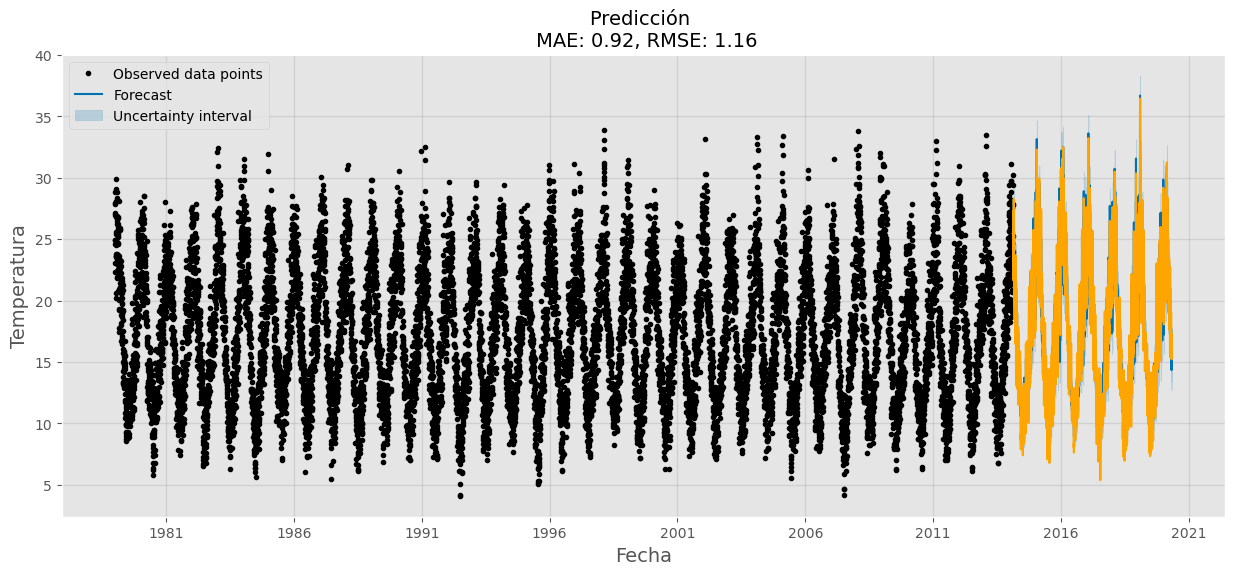

In [18]:
# Visualizar las predicciones
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange')

ax.set_title(f'Predicción \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Fecha', fontsize=14)
ax.set_ylabel(ylabel='Temperatura', fontsize=14)

plt.show()

  0%|          | 0/66 [00:00<?, ?it/s]

13:38:44 - cmdstanpy - INFO - Chain [1] start processing
13:38:44 - cmdstanpy - INFO - Chain [1] done processing
13:38:44 - cmdstanpy - INFO - Chain [1] start processing
13:38:44 - cmdstanpy - INFO - Chain [1] done processing
13:38:45 - cmdstanpy - INFO - Chain [1] start processing
13:38:45 - cmdstanpy - INFO - Chain [1] done processing
13:38:46 - cmdstanpy - INFO - Chain [1] start processing
13:38:46 - cmdstanpy - INFO - Chain [1] done processing
13:38:46 - cmdstanpy - INFO - Chain [1] start processing
13:38:46 - cmdstanpy - INFO - Chain [1] done processing
13:38:47 - cmdstanpy - INFO - Chain [1] start processing
13:38:47 - cmdstanpy - INFO - Chain [1] done processing
13:38:47 - cmdstanpy - INFO - Chain [1] start processing
13:38:48 - cmdstanpy - INFO - Chain [1] done processing
13:38:48 - cmdstanpy - INFO - Chain [1] start processing
13:38:49 - cmdstanpy - INFO - Chain [1] done processing
13:38:49 - cmdstanpy - INFO - Chain [1] start processing
13:38:49 - cmdstanpy - INFO - Chain [1]

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 37 days  1.487205  1.219510  0.962144  0.068635  0.045839  0.067020   
1 38 days  1.491006  1.221068  0.962548  0.068846  0.045833  0.067125   
2 39 days  1.474693  1.214369  0.955715  0.068391  0.045529  0.066657   
3 40 days  1.454387  1.205980  0.945337  0.067733  0.044528  0.065945   
4 41 days  1.447398  1.203078  0.941838  0.067401  0.044313  0.065597   

   coverage  
0  0.793483  
1  0.793898  
2  0.796181  
3  0.801993  
4  0.804068  


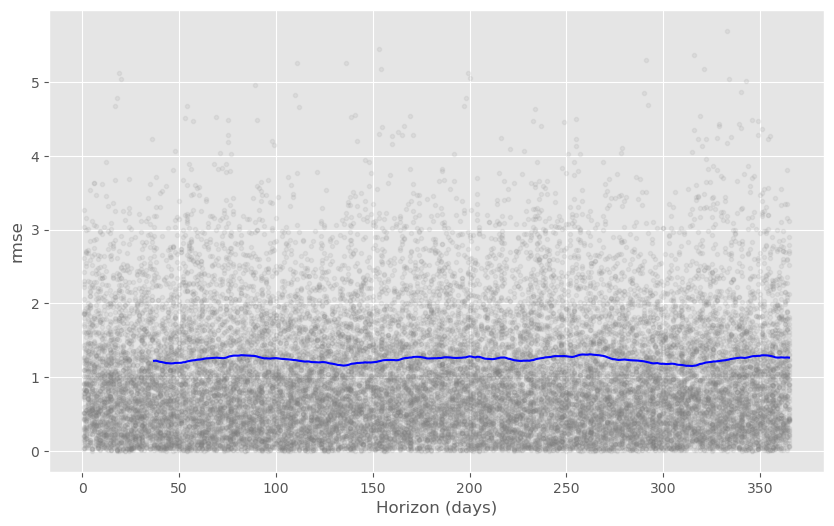

In [19]:
# Realizar validación cruzada
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')

# Visualizar métricas de validación cruzada
df_p = performance_metrics(df_cv)
print(df_p.head())

# Visualizar la métrica RMSE a lo largo del horizonte de predicción
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()

In [20]:
def evaluate_prophet_model(params, train_data, valid_data):
    model = Prophet(**params)
    model.add_regressor('etp')
    model.add_regressor('prec')

    model.fit(train_data)

    y_pred = model.predict(valid_data)
    y_true = valid_data['y']

    mse = mean_squared_error(y_true, y_pred['yhat'])
    return mse

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5],
    'holidays_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Realizar la búsqueda de cuadrícula
best_params = None
best_mse = float('inf')

for params in ParameterGrid(param_grid):
    mse = evaluate_prophet_model(params, train_data, valid_data)
    
    if mse < best_mse:
        best_mse = mse
        best_params = params

print("Mejores hiperparámetros:", best_params)
print("Mejor MSE encontrado:", best_mse)

13:41:34 - cmdstanpy - INFO - Chain [1] start processing
13:41:37 - cmdstanpy - INFO - Chain [1] done processing
13:41:39 - cmdstanpy - INFO - Chain [1] start processing
13:41:41 - cmdstanpy - INFO - Chain [1] done processing
13:41:43 - cmdstanpy - INFO - Chain [1] start processing
13:41:45 - cmdstanpy - INFO - Chain [1] done processing
13:41:48 - cmdstanpy - INFO - Chain [1] start processing
13:41:50 - cmdstanpy - INFO - Chain [1] done processing
13:41:52 - cmdstanpy - INFO - Chain [1] start processing
13:41:54 - cmdstanpy - INFO - Chain [1] done processing
13:41:57 - cmdstanpy - INFO - Chain [1] start processing
13:41:59 - cmdstanpy - INFO - Chain [1] done processing
13:42:01 - cmdstanpy - INFO - Chain [1] start processing
13:42:03 - cmdstanpy - INFO - Chain [1] done processing
13:42:06 - cmdstanpy - INFO - Chain [1] start processing
13:42:08 - cmdstanpy - INFO - Chain [1] done processing
13:42:10 - cmdstanpy - INFO - Chain [1] start processing
13:42:12 - cmdstanpy - INFO - Chain [1]

Mejores hiperparámetros: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
Mejor MSE encontrado: 1.3563488705342202


In [21]:
# Crear un nuevo modelo con los mejores hiperparámetros
best_model = Prophet(changepoint_prior_scale=0.1, 
                     holidays_prior_scale=0.1, 
                     seasonality_mode='multiplicative', 
                     seasonality_prior_scale=0.5)

# Añadir regresores si es necesario (etp y prec)
best_model.add_regressor('etp')
best_model.add_regressor('prec')

In [22]:
# Ajustar el modelo con todos los datos
full_data = pd.concat([train_data, valid_data])  # Concatenar conjuntos de entrenamiento y validación
best_model.fit(full_data)

13:47:17 - cmdstanpy - INFO - Chain [1] start processing
13:47:22 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# Cambiar el nombre de la columna 'etp' a 'y'
prophet_data_etp = prophet_data[['ds', 'etp']]
prophet_data_etp = prophet_data_etp.rename(columns={'etp': 'y'})

# Crear un modelo de predicción para el regresor etp
model_etp = Prophet()
model_etp.fit(prophet_data_etp)

# Cambiar el nombre de la columna 'prec' a 'y'
prophet_data_prec = prophet_data[['ds', 'prec']]
prophet_data_prec = prophet_data_prec.rename(columns={'prec': 'y'})

# Crear un modelo de predicción para el regresor prec
model_prec = Prophet()
model_prec.fit(prophet_data_prec)

# Crear un DataFrame de fechas futuras extendidas a 4 años
future_extended = model_etp.make_future_dataframe(periods=365 * 4, freq='D')

# Generar las predicciones futuras de los regresores
forecast_etp = model_etp.predict(future_extended)
forecast_prec = model_prec.predict(future_extended)

13:47:24 - cmdstanpy - INFO - Chain [1] start processing
13:47:27 - cmdstanpy - INFO - Chain [1] done processing
13:47:30 - cmdstanpy - INFO - Chain [1] start processing
13:47:30 - cmdstanpy - INFO - Chain [1] done processing


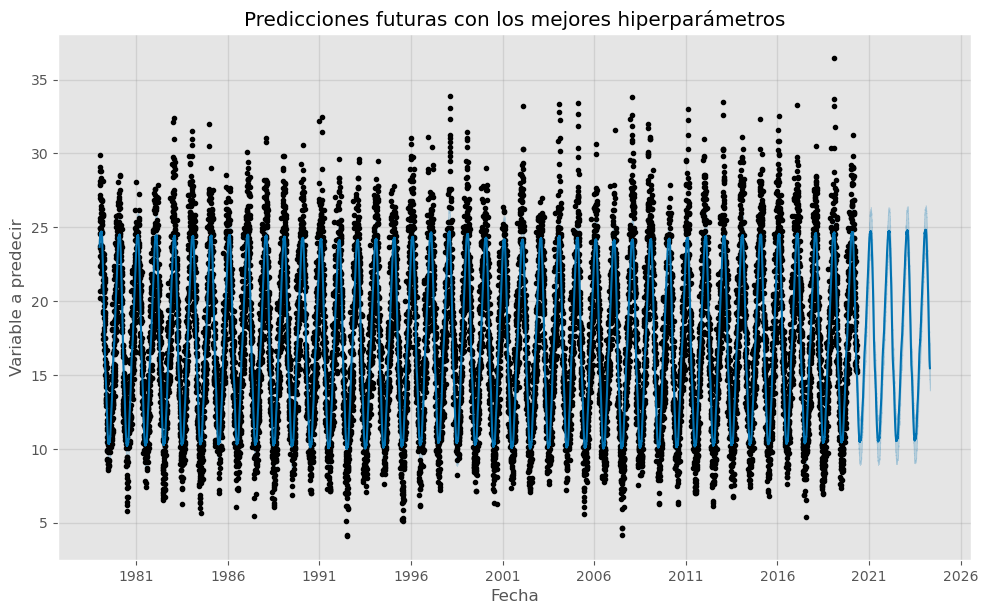

In [24]:
# Crear un DataFrame con las fechas futuras a predecir 4 años
future_dates = best_model.make_future_dataframe(periods=365 * 4, freq='D')

# Añadir las predicciones de 'etp' y 'prec' al DataFrame future_dates
future_dates['etp'] = forecast_etp['yhat'].values
future_dates['prec'] = forecast_prec['yhat'].values

# Realizar la predicción para las fechas futuras
forecast = best_model.predict(future_dates)

# Visualizar las predicciones
best_model.plot(forecast)
plt.title('Predicciones futuras con los mejores hiperparámetros')
plt.xlabel('Fecha')
plt.ylabel('Variable a predecir')
plt.show()

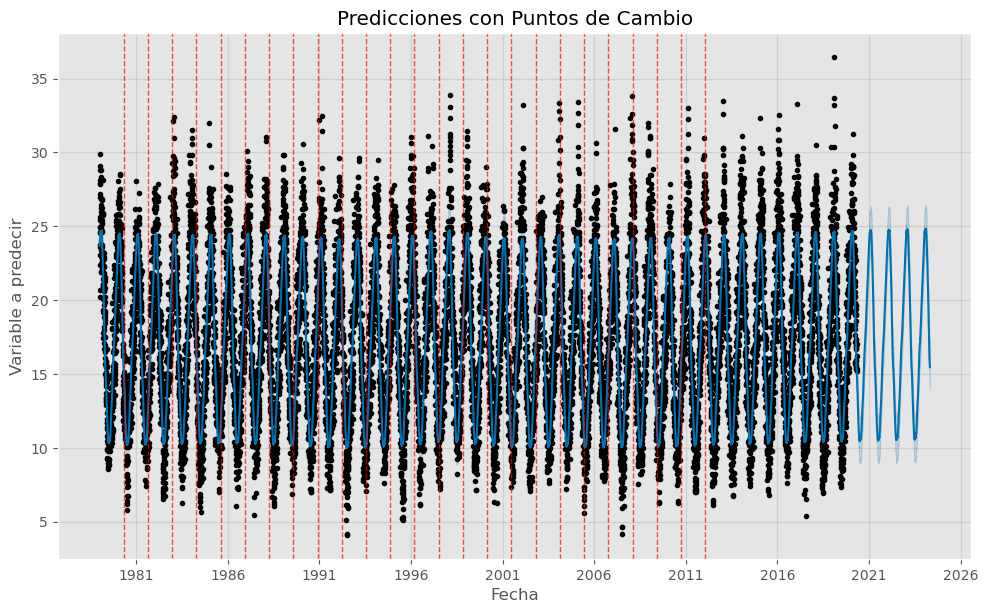

In [25]:
# Visualizar las predicciones
fig = best_model.plot(forecast)

# Obtener los puntos de cambio
changepoints = best_model.changepoints

# Añadir líneas verticales para los puntos de cambio
for changepoint in changepoints:
    plt.axvline(changepoint, color='red', linestyle='--', linewidth=1, alpha=0.7)

# Ajustar leyenda y título
plt.title('Predicciones con Puntos de Cambio')
plt.xlabel('Fecha')
plt.ylabel('Variable a predecir')
plt.show()

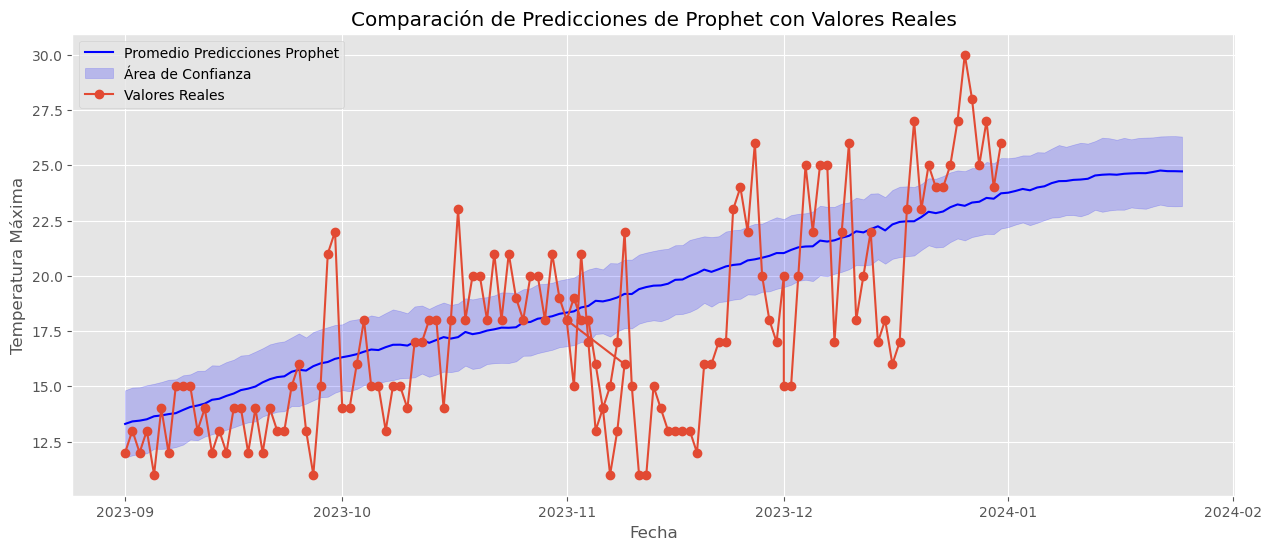

In [26]:
import pandas as pd

# Filtrar las predicciones para septiembre 2023, octubre 2023, noviembre 2023, diciembre 2023 y enero 2024.
testing = forecast[(forecast['ds'] >= '2023-09-01') & (forecast['ds'] <= '2024-01-25')]

# Datos reales obtenidos en mismo periodo
temperaturas_maximas = {
    "septiembre_2023": [12, 13, 12, 13, 11, 14, 12, 15, 15, 15, 13, 14, 12, 13, 12, 14, 14, 12, 14, 12, 14, 13, 13, 15, 16, 13, 11, 15, 21, 22],
    "octubre_2023": [14, 14, 16, 18, 15, 15, 13, 15, 15, 14, 17, 17, 18, 18, 14, 18, 23, 18, 20, 20, 18, 21, 18, 21, 19, 18, 20, 20, 18, 21, 19, 18, 15, 21, 17, 13, 14, 11, 13, 16],
    "noviembre_2023": [18, 19, 18, 18, 16, 14, 15, 17, 22, 15, 11, 11, 15, 14, 13, 13, 13, 13, 12, 16, 16, 17, 17, 23, 24, 22, 26, 20, 18, 17, 20],
    "diciembre_2023": [15, 15, 20, 25, 22, 25, 25, 17, 22, 26, 18, 20, 22, 17, 18, 16, 17, 23, 27, 23, 25, 24, 24, 25, 27, 30, 28, 25, 27, 24, 26],
}

# Mapear los nombres de los meses a números
meses_dict = {
    "enero": 1, "febrero": 2, "marzo": 3, "abril": 4, "mayo": 5, "junio": 6,
    "julio": 7, "agosto": 8, "septiembre": 9, "octubre": 10, "noviembre": 11, "diciembre": 12
}

# Crear un DataFrame para las temperaturas reales
temperaturas_df = pd.DataFrame()

for month, temperatures in temperaturas_maximas.items():
    month_num = meses_dict[month.split("_")[0]]
    date_range = pd.date_range(start=f'2023-{month_num:02d}-01', periods=len(temperatures), freq='D')
    df_temp = pd.DataFrame({'Fecha': date_range, 'Temperatura_Maxima': temperatures})
    temperaturas_df = pd.concat([temperaturas_df, df_temp], ignore_index=True)

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(15, 6))

# Graficar las predicciones de Prophet
ax.plot(testing['ds'], (testing['yhat_lower'] + testing['yhat_upper']) / 2, color='blue', label='Promedio Predicciones Prophet')

# Rellenar el área entre yhat_lower y yhat_upper
ax.fill_between(testing['ds'], testing['yhat_lower'], testing['yhat_upper'], color='blue', alpha=0.2, label='Área de Confianza')

# Graficar los valores reales
ax.plot(temperaturas_df['Fecha'], temperaturas_df['Temperatura_Maxima'], marker='o', label='Valores Reales')

# Configurar etiquetas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Temperatura Máxima')
ax.set_title('Comparación de Predicciones de Prophet con Valores Reales')
ax.legend()

# Mostrar la gráfica
plt.show()

Se observa que la predicción de Prophet se encuentra dentro del área de confianza de los valores reales actuales. Esto indica que la predicción es razonablemente precisa, y que es probable que las temperaturas máximas en esta zona continúen aumentando en los próximos años.

Sin embargo, también se observa que la predicción se desvía ligeramente de los valores reales actuales en los últimos meses. Esto puede deberse a factores aleatorios, o a cambios en las condiciones climáticas que no fueron tomados en cuenta en la predicción.

En comparación con los valores reales actuales de las temperaturas máximas en esta zona, la predicción de Prophet muestra un buen ajuste. Sin embargo, es importante tener en cuenta que la predicción es bastante futura, y que el clima es un sistema complejo que es difícil de predecir con precisión a largo plazo.